In [1]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [2]:
#from the Lyaponov orbit
#x0_lyapunov = [ 1.1556814491008298,
# -1.4319993886822296e-21,
#  0.0,
#  2.2212106056655213e-21,
# -8.333136405918907e-6,
#  0.0]



 #lyapunov_period = 3.3732524857835884


In [3]:
#parameters for Earth Moon System
μ = 1.215e-2
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook
L = 3.850e5 #in km - distance between centers of m1 and m2
V_ = 1.025 #in km/s - orbital velocity of m1
T_ = 2.361e6 #in seconds - orbital period of m1 and m2

time_scale = T_/(2*pi)

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
XL2 = [1.1556799130947355, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.1556799130947355
 0.0
 0.0
 0.0
 0.0
 0.0

In [4]:
#to get into normalized units, divide by this scale. To get normalized units to standard metric units multiply
acceleration_scale = L/((time_scale)^2)

2.726644335279151e-6

In [5]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [6]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [7]:
#x[1:6] -> state
#x[7:9] -> control inputs

function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [8]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [9]:
function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [10]:
#input is the initial condition
#control trajectory u (size N-1)

#integrate every half orbit

#u is size 20

#40 knot points in one rev. each of them are equally spaced apart

function integrate_halfperiod(x_0, u)
    
    #u will be size 20
    
    #x trajectory not delta x 

    xtraj = zeros(6, 21)

    xtraj[:,1] = x_0

    #go through all the controls
    for i=1:20
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
        
    end
    
    #this is size N. 21. Element 21 is the new 1
    return xtraj
        
end

integrate_halfperiod (generic function with 1 method)

In [11]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [12]:
#ODE for the state transition matrix 

function phi_ode(z)
    
    #state vector
    x = z[1:6]
    
    #state transition matrix
    Φ = reshape(z[7:end], (6,6))
    
    #Find the dynamics jacobian at the state vector
    F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics(dx), x)
    
    #Differential Equation of State transition Matrix
    Φ_dot = F*Φ
    
    return vec(Φ_dot)
    
end

phi_ode (generic function with 1 method)

In [13]:
#3BP dynamics and state transition matrix dynamics in one function 
function ST_and_dynamics(z)
    x = z[1:6]
    Φ = z[7:end]
    
    x_dot = three_body_prob_dynamics(x)
    Φ_dot = phi_ode(z)
    
    z_dot = [x_dot; Φ_dot]
    
    return z_dot
end

ST_and_dynamics (generic function with 1 method)

In [14]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics(u[1:6])
    du[7:end] = phi_ode(u)
    
end

ST_and_dynamics_DFJL! (generic function with 1 method)

In [15]:
#solve using DifferentialEquations.jl
function justdynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics(u[1:6])
    
end

justdynamics_DFJL! (generic function with 1 method)

In [16]:
#gets the state and state transition matrix for the entire solution

function get_state_stm(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    all_stm = zeros(6,6,N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
        all_stm[:,:,i] = reshape(solution.u[i][7:end], (6,6)) 
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states, all_stm, solution.t 
end

get_state_stm (generic function with 1 method)

In [17]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [18]:
#gets the state and transition matrix for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [19]:

#this solved until we cross the xz plane
function diff_solve(x_0, period)
    
    #stop when y=0
    condition(u,t,integrator) = u[2]
    
    affect!(integrator) = terminate!(integrator)
    
    cb = ContinuousCallback(condition, affect!)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol = 1e-12, reltol=1e-12, callback=cb)
    
    return sol
    
end

diff_solve (generic function with 1 method)

In [20]:
#integrate dynamics and state transition matrix
function dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_integrate (generic function with 1 method)

In [21]:
#integrate just the dynamics
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(justdynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [22]:
3.4071472466192527*time_scale

1.2802860740198337e6

In [23]:
using DelimitedFiles
#period of the halo orbit. From ThreeBodyProblem.jl
T = 3.4071472466192527

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
richardson  = readdlm("richardsonL2.txt", '\t', Float64, '\n')'

x0_L2 = richardson[:,1]

#for lyaponov
#x0_L2 = x0_lyapunov

#T = lyapunov_period

6-element Vector{Float64}:
 1.1201297302380415
 0.0
 0.014654708958207016
 0.0
 0.17331212810099958
 0.0

In [24]:
#linearize the dynamics about the L2 Lagrange Point and go in the planar direction
AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), XL2)

6×6 Matrix{Float64}:
  0.0       0.0       0.0       1.0   0.0   0.0
  0.0       0.0       0.0       0.0   1.0   0.0
  0.0       0.0       0.0       0.0   0.0   1.0
  7.38087   0.0       0.0       0.0   2.0   0.0
 -0.0      -2.19044  -0.0      -2.0  -0.0  -0.0
 -0.0      -0.0      -3.19044  -0.0  -0.0  -0.0

In [25]:
#nonzero_cmplx_eigen_L2 = cmplx_eigen_L2[cmplx_eigen_L2 .!=0]

In [26]:
#marginally stable directions (periodic motion)
#direction2_L2 = A_L2_eigen.vectors[:, 2]
#direction3_L2 = A_L2_eigen.vectors[:, 3]
#direction4_L2 = A_L2_eigen.vectors[:, 4]
#direction5_L2 = A_L2_eigen.vectors[:, 5]

In [27]:
#display(direction2_L2)
#display(direction3_L2)
#display(direction4_L2)
#display(direction5_L2)
#directions 2 and 3 correspond to out of plane motion. We will select a perturbation
#in plane to get a Lyaponov orbit

In [28]:
#nonzero_cmplx_eigen_L2

In [29]:
#real(direction2_L2)

In [30]:
#real(direction3_L2)

In [31]:
#real(direction4_L2)

In [32]:
#real(direction5_L2)

In [33]:
#we will perturb the L2 lagrange point by direction 5 (planar stable direction)
#approximate the period of Lyaponov orbit with T = |omega|/(2π) where omega = |λ_5|

#λ_planar = norm(A_L2_eigen.values[5])
#T_planar = 2*pi/λ_planar

#set T to whatever direction you use
#T = T_planar

#weight of the perturbation (1e-3 works)
#w2 = 1e-5

#this is the perturbation in the planar direction
#perturbation_planar_L2 = w2*(real(direction5_L2))

#this is a linear combination between both of the directions
#x0_L2 = XL2 + perturbation_planar_L2

In [34]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2; Φ_0]

solution_in = dynamics_integrate(x_0_stm, T)

all_state_in, stm_in, sol_t_in = get_state_stm(solution_in)

([1.1201297302380415 1.1201315793894473 … 0.9598168359898963 0.9601713534220018; 0.0 0.002749466088557135 … -0.1169121350923755 -0.1172922996760091; … ; 0.17331212810099958 0.17320299972633757 … -0.029955511950586725 -0.017751032310781314; 0.0 -0.0013561046076076924 … 0.02590301832776876 0.02739485752939118], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0015713531460613 7.090514858391351e-6 … 0.0002519065358273217 1.1438607094496763e-6; -3.086698612464229e-6 0.9993916134512492 … 0.01586169617188272 2.6498267536445577e-9; … ; -0.000583496383959822 -0.07665588588942303 … 0.9988886487108988 6.673536414028363e-7; 0.027262012051412838 0.0002792703296158481 … 5.240284891879581e-6 0.9992894271883602;;; 1.0080003686062222 8.117874078240962e-5 … 0.0012847681230624035 1.3111158861986725e-5; -3.541048474710067e-5 0.9969079306213369 … 0.035730603567059024 6.811595437706528e-8; … ; -0.0029652318462916227 -0.17244118009599924 … 0.9943602906842132 7.57446403010

In [35]:
#a = LinRange(1,2,10)

In [36]:
#solution_in(a).u[2]

In [37]:
initial_norm = all_state_in[:,end] - all_state_in[:,1]

6-element Vector{Float64}:
 -0.15995837681603975
 -0.1172922996760091
 -0.02626106608221971
  0.02291137489818987
 -0.1910631604117809
  0.02739485752939118

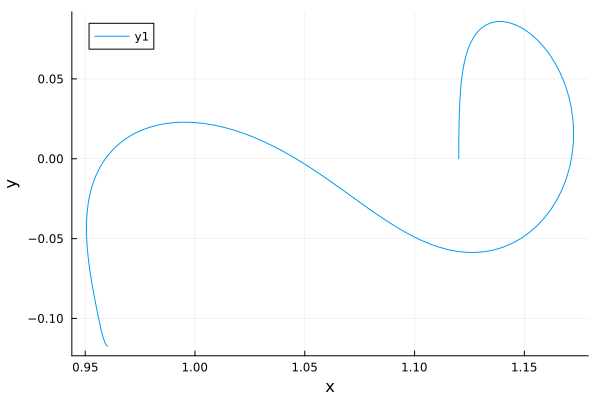

In [38]:
#this is if we rollout our dynamics with the stable initial condition
#almost periodic, can be fixed with a differential corrector
#plot(all_state_in[1,:], all_state_in[2,:], all_state_in[3,:], xlabel="x", ylabel="y", zlabel="z")

plot(all_state_in[1,:], all_state_in[2,:], xlabel="x", ylabel="y")

In [39]:
#fix with a single shooting differential corrector
function differential_corrector(x_0_stm, Tp)
    
    #this is the final time it converges to
    T_f = 0

    #Iterate to bring the δx at T/2 to the desired state
    max_iters = 1000

    #keep z0 fixed and change only x0 and y_dot_0
    for i=1:max_iters
    #for i=1:100

        solution = diff_solve(x_0_stm, Tp)

        #this is the state, STM, and time when y crosses the XZ plane 
        all_state, stm, sol_t = get_state_stm(solution)

        #display(stm)

        T2_state = all_state[:,end]

        #T2_state -> x,y,z, xdot, ydot, zdot
        #desired xdot an xzdot
        xz_d = [0, 0]

        rv = T2_state[1:6]

        rv_dot = three_body_prob_dynamics(rv)

        #desired state subtracted by state at t/2
        δxz = xz_d - [T2_state[4], T2_state[6]]

        #subset of the state transition matrix

        #all 6 variables 
        #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

        #to change x and ydot 

        #keep z0 constant
        #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

        #keep x0 constant
        stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
        dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


        #keep y0 constant
        #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]


        delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        
        #println("THIS IS CONDITION NUMBER")
        #println(cond((stm_s - dy/rv_dot[2])))

        #delta_x0 = stm_s\δxz

        #update the initial state

        #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
        x_0_stm[3] = x_0_stm[3] + delta_x0[1]
        x_0_stm[5] = x_0_stm[5] + delta_x0[2]

        #x_0_stm[1:6] = x_0_stm[1:6] + delta
        #when delta is below a set tolerance we are done

        println("residual: ", δxz)
        
        if norm(δxz) < 1e-10
            #this is the total time, but we use it to ensure we have enough time to find where
            #y crosses the xz plane
            #print("this is sol t: ", sol_t)
            #updating time
                    
            T_f = sol_t[end]*2
            break
        end

    end
    
    corrected_solution = dynamics_integrate(x_0_stm, T_f)

    all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
    return all_state_final, stm_final, sol_t_final, corrected_solution
    
end

differential_corrector (generic function with 1 method)

In [40]:
x_0_stm

42-element Vector{Float64}:
 1.1201297302380415
 0.0
 0.014654708958207016
 0.0
 0.17331212810099958
 0.0
 1.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [41]:
#run the differential corrector to get the corrected solution
all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(x_0_stm, T)

residual: [0.01857080236883737, -0.0021632545995316417]
residual: [2.8312173778893818e-5, 0.00040005301748527873]
residual: 

[-0.005593063012988634, 0.0006855671710273909]
residual: [-0.0002753554627994218, 9.609722632526362e-5]
residual: [-0.00124790154320579, 0.00010776928075096125]
residual: [-0.00014839275121582976, 1.9859430292932176e-5]
residual: [-0.00016349174566511067, 1.1434585456229484e-5]
residual: [-1.7001852048082146e-5, 1.4152697452431822e-6]
residual: [-1.2965946293622829e-6, 8.763231880264093e-8]
residual: [-2.067202012604848e-9, 1.8287207814728518e-10]
residual: [-2.4311484826950574e-10, -9.094832474900328e-12]
residual: [2.6881047955209715e-10, 1.00602907478554e-11]
residual: [-2.229120491450085e-10, -8.341007708186055e-12]
residual: [1.5653552014793573e-10, 5.858712308915186e-12]
residual: [5.521886585522387e-12, 2.0892289300330166e-13]


([1.1201297302380415 1.1201311081188294 … 1.1201313201956895 1.1201297247305944; 0.0 0.0028013809910646193 … -0.0030131577097136215 6.570385800730957e-9; … ; 0.17677819141944426 0.17666637059384038 … 0.17664883388835512 0.176778202120717; 0.0 -0.0005565101221602515 … 0.0005985582943211904 -9.59632381217647e-10], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0016074883709059 7.5804311225973746e-6 … 0.00025136138370891677 4.738211992493981e-7; -2.8757725808721976e-6 0.9993829724405194 … 0.015844299170138736 1.1950669931416683e-9; … ; -0.0005442279146014368 -0.07782864945011787 … 0.9988811443374926 3.013082664426108e-7; 0.01131746896886859 0.00011816242021569976 … 2.195516203519792e-6 0.9992614228077492;;; 1.0080661616809419 8.491747541014842e-5 … 0.00126360659271463 5.3138827001967e-6; -3.228465744021556e-5 0.9969092557866961 … 0.03543423089128573 2.98489886816867e-8; … ; -0.0027263784431498343 -0.17380305899628315 … 0.9944044720641597 3.34742847545

In [42]:
#stm_final

In [43]:
#Finding the unstable direction for the unstable manifold to encode as a constraint

#monodromy = stm_final[:,:,end]

In [44]:
all_state_final

6×79 Matrix{Float64}:
 1.12013      1.12013       1.12014      …   1.12013       1.12013
 0.0          0.00280138    0.00626909      -0.00301316    6.57039e-9
 0.00593968   0.00593526    0.00591757       0.00593457    0.00593968
 0.0          0.000174556   0.000403396     -0.000188008  -1.63335e-8
 0.176778     0.176666      0.176218         0.176649      0.176778
 0.0         -0.00055651   -0.00124418   …   0.000598558  -9.59632e-10

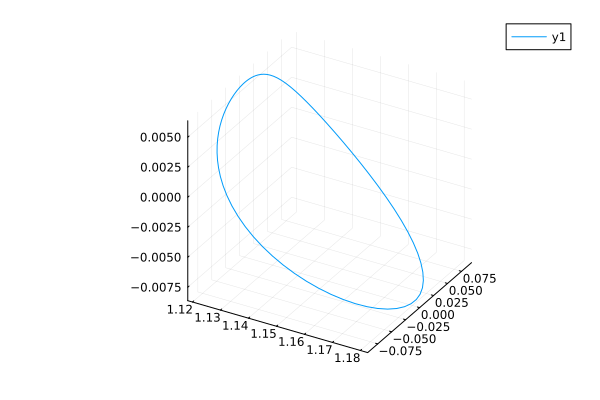

In [45]:
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [46]:
final_norm = all_state_final[:,end] - all_state_final[:,1]

6-element Vector{Float64}:
 -5.507447164987411e-9
  6.570385800730957e-9
 -1.346415930136846e-10
 -1.633346660459268e-8
  1.0701272729063405e-8
 -9.59632381217647e-10

In [47]:
#Check when the orbit leave
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(x_0_stm, 3.5*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([1.1201297302380415 1.1201311081188294 … 1.1110655555713855 1.113575563284056; 0.0 0.0028013809910646193 … -0.03133790702360431 -0.03142771820527147; … ; 0.17677819141944426 0.17666637059384038 … -0.005070888875362288 -0.007689189775005213; 0.0 -0.0005565101221602515 … -0.014039639233851898 -0.013993448934656288], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0016074883709059 7.5804311225973746e-6 … 0.00025136138370891677 4.738211992493981e-7; -2.8757725808721976e-6 0.9993829724405194 … 0.015844299170138736 1.1950669931416683e-9; … ; -0.0005442279146014368 -0.07782864945011787 … 0.9988811443374926 3.013082664426108e-7; 0.01131746896886859 0.00011816242021569976 … 2.195516203519792e-6 0.9992614228077492;;; 1.0080661616809419 8.491747541014842e-5 … 0.00126360659271463 5.3138827001967e-6; -3.228465744021556e-5 0.9969092557866961 … 0.03543423089128573 2.98489886816867e-8; … ; -0.0027263784431498343 -0.17380305899628315 … 0.9944044720641597 3.34742847

In [48]:
all_state_lp

6×412 Matrix{Float64}:
 1.12013      1.12013       1.12014      …   1.11107       1.11358
 0.0          0.00280138    0.00626909      -0.0313379    -0.0314277
 0.00593968   0.00593526    0.00591757      -0.000411915  -0.000609201
 0.0          0.000174556   0.000403396      0.181161      0.175591
 0.176778     0.176666      0.176218        -0.00507089   -0.00768919
 0.0         -0.00055651   -0.00124418   …  -0.0140396    -0.0139934

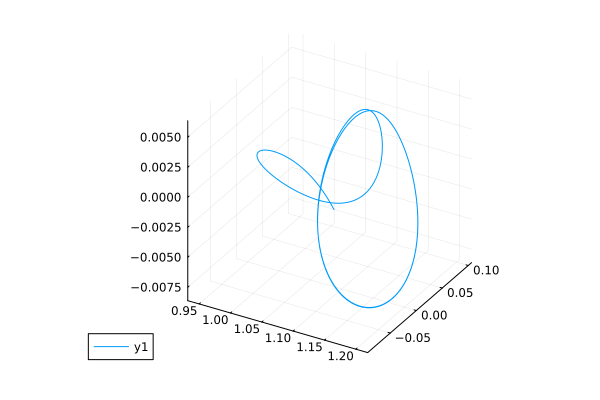

In [49]:
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

In [50]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [51]:
#this is the continuous dynamics
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), all_state_final[:,1])

In [52]:
#this is including the slack variable in the control vector
#B = [zeros(3,4); I][1:6, :]

In [53]:
nx = 6 #number of states
nu = 3 #number of controls 

3

In [54]:
#this is the A tilde to get the discretized dynamics
#Ã = [AL2 B; zeros(4,10)]

#this is the number of knot points in one horizon
N_period = 41  #40 knot points per period per period

N_h = 82 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.08537438534157255

In [55]:
# function get_reference(i,N)
    
#     reference = zeros(nx, N)

#     for k=1:N

#         reference[:,k] = full_solution(horizon[i:end]).u[k][1:6]
        
#     end

#     return reference
    
# end

In [56]:
#Ad = H[1:nx, 1:nx]
#Bd = H[1:nx, nx+1:end]

In [57]:
#umin = 0.5
#umax = 1

In [58]:
#N (number of knot points) 6x6 discrete dynamics jacobians

#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [59]:
T_corrected = sol_t_final[end]

3.414975413662902

In [60]:
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.0853744, 0.170749, 0.256123, …, 3.15885, 3.24423, 3.3296, 3.41498

In [61]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [62]:
horizon

41-element LinRange{Float64, Int64}:
 0.0, 0.0853744, 0.170749, 0.256123, …, 3.15885, 3.24423, 3.3296, 3.41498

In [63]:
full_solution(horizon).u[1][7:end]

36-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [64]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = full_solution(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(full_solution(horizon).u[k][7:end], (6,6)) 
        
end

In [65]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
  0.2601199344043385
 -0.28147013927572373
  0.006120783674633997
  0.7718088379884933
 -0.5053799680278542
  0.044462590430748905

In [66]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [67]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy

for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end



In [68]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
  0.26012      0.278863     0.30114    …   0.246145     0.26012
 -0.28147     -0.270564    -0.258354      -0.291121    -0.28147
  0.00612078   0.00871106   0.0111223      0.00348289   0.00612078
  0.771809     0.817609     0.850311       0.715593     0.771809
 -0.50538     -0.422152    -0.342235      -0.584001    -0.50538
  0.0444626    0.0475123    0.0478662  …   0.0389806    0.0444626

In [69]:
[unstable_directions[1:3, 1]; zeros(3)]

6-element Vector{Float64}:
  0.2601199344043385
 -0.28147013927572373
  0.006120783674633997
  0.0
  0.0
  0.0

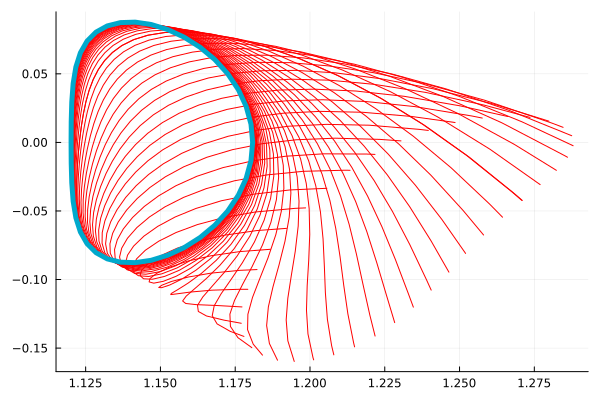

In [70]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left
epz = 1e-5
#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit")

plot(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Orbit")


for i=1:41

    #initial_state = reference_trajectory[:,i] + epz.*unstable_directions[:,i]

    initial_state = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    #initial_state = reference_trajectory[:,i] - epz.*unstable_directions[:,i]

    inv_manifold = just_dynamics_integrate(initial_state, 1.5*sol_t_final[end])

    all_state_m = get_state(inv_manifold)

    #plot!(all_state_m[1,:], all_state_m[2,:], all_state_m[3,:], color="red", legend=false)

    plot!(all_state_m[1,:], all_state_m[2,:], color="red", legend=false)

end

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit", linewidth = 5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Orbit", linewidth = 5)


In [71]:
#two orbits worth of data
unstable_constraint = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
  0.26012      0.278863     0.30114    …   0.246145     0.26012
 -0.28147     -0.270564    -0.258354      -0.291121    -0.28147
  0.00612078   0.00871106   0.0111223      0.00348289   0.00612078
  0.771809     0.817609     0.850311       0.715593     0.771809
 -0.50538     -0.422152    -0.342235      -0.584001    -0.50538
  0.0444626    0.0475123    0.0478662  …   0.0389806    0.0444626

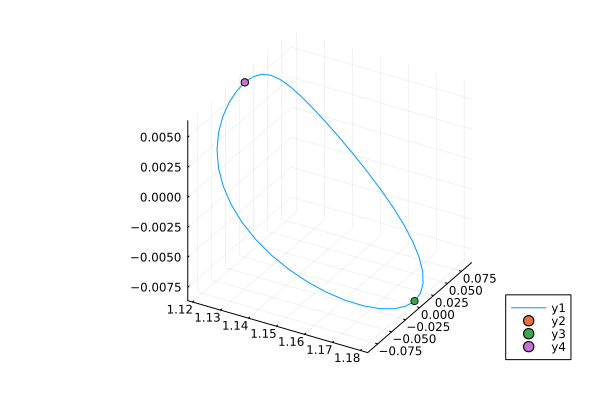

In [72]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])
scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])
scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

In [73]:
#obtain the reference trajectory at the knot points that we made up

#reference_trajectory = get_reference(1,N_period)

In [74]:
#goal is to have a look ahead of 2 orbits and apply an MPC controller 

#3 periods worth of data (just using the same orbit over the 3 periods)
#reference_trajectory_all = [reference_trajectory reference_trajectory reference_trajectory]

In [75]:
function three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)

    #q_original = zeros(eltype(x),3)
    #v_original = zeros(eltype(x),3)
    #u_original = zeros(eltype(x),3)

    #q_original = x[1:3] 
    #v_original = x[4:6]
    #u_original = u
    
    x_original = [x; u]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    ẋ_scaled = ẋ_original[1:6]

    u_scaled = ẋ_original[7:9]*1.0

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled_RK4 (generic function with 1 method)

In [76]:
#RK4 integrator with a zero order hold

function RK4_integrator(x, u)

    
    xnext = zeros(eltype(x),6)

    f1 = three_body_prob_dynamics_wcontrol_RK4(x, u)
    f2 = three_body_prob_dynamics_wcontrol_RK4(x+0.5*Δt*f1, u)
    f3 = three_body_prob_dynamics_wcontrol_RK4(x+0.5*Δt*f2, u)
    f4 = three_body_prob_dynamics_wcontrol_RK4(x+ Δt*f3, u)

    xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

    return xnext

end


RK4_integrator (generic function with 1 method)

In [77]:
#u0 = zeros(3)
#Ak_rk4 = ForwardDiff.jacobian(x_-> RK4_integrator(x_, u0), reference_trajectory[:,1])

In [78]:
$#Bk_rk4 = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,1], u_), u0)

UndefVarError: UndefVarError: `$` not defined

In [79]:
#Bk_rk4 = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,1], u_), u0)

In [80]:
#going to update the dynamics jacobians with the rk4 integrator
for i=1:N_period

    #get the discrete dynamics jacobians for the entire reference trajectory along the knot points

    Ak = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), reference_trajectory[:,i])

    #this is including the slack variable in the control vector (this is control on accelerations/thrust)
    Bk = [zeros(3,3); I]

    #this is the A tilde to get the discretized dynamics
    Ãk = [Ak Bk; zeros(3,9)]

    H = exp(Ãk*Δt)

    all_Ad[:,:,i] = H[1:nx, 1:nx]

    all_Bd[:,:,i] = H[1:nx, nx+1:end]

    #rk4 Bd jacobian is having a type error ...
    #all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(x_, zeros(3)), reference_trajectory[:,i])

    #all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,i], u_), zeros(3))
    
    
end

In [81]:
all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.04689     -0.00102071   0.00260771   0.0862903   0.00730606   7.41575e-5
 -0.00265804   0.982189    -0.00014805  -0.00730606  0.084451    -3.16068e-6
  0.00261403  -2.65229e-7   0.97864      7.41575e-5  3.16068e-6   0.0847656
  1.10423     -0.0359011    0.0611981    1.03227     0.17156      0.00260771
 -0.0934914   -0.414982    -0.00519988  -0.17156     0.967577    -0.00014805
  0.0614942   -1.55312e-5  -0.498558     0.00260771  0.00014805   0.97864

[:, :, 2] =
 1.04578      0.00542008    0.00248581   …  0.00748696   7.05816e-5
 0.0038039    0.982914      0.000135678     0.084482     4.85583e-6
 0.00247613   0.000276349   0.979008        1.08441e-5   0.0847761
 1.08221      0.116062      0.0585165       0.177917     0.00248581
 0.0592169   -0.402306      0.00154299      0.968665     0.000135678
 0.0582473    0.0064858    -0.490018     …  0.000416173  0.979008

[:, :, 3] =
 1.04219      0.0106272     0.00213456   …  0.00762921   6.0522e-5
 0.00

In [82]:
#concatenate jacobians for two periods

all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

6×3×82 Array{Float64, 3}:
[:, :, 1] =
  0.00366392  0.00020772   1.58222e-6
 -0.00020772  0.00362468  -5.39756e-8
  1.58222e-6  5.39756e-8   0.00363139
  0.0862903   0.00730606   7.41575e-5
 -0.00730606  0.084451    -3.16068e-6
  7.41575e-5  3.16068e-6   0.0847656

[:, :, 2] =
  0.00366303   0.000211581  1.50452e-6
 -0.000203843  0.00362534   1.1639e-7
  1.49309e-6   2.18652e-7   0.00363161
  0.0862486    0.00748696   7.05816e-5
 -0.00712425   0.084482     4.85583e-6
  6.99121e-5   1.08441e-5   0.0847761

[:, :, 3] =
  0.00366069  0.000214621  1.28897e-6
 -0.00020076  0.00362705   2.3647e-7
  1.26985e-6  3.23769e-7   0.00363223
  0.0861388   0.00762921   6.0522e-5
 -0.00697951  0.0845623    1.05698e-5
  5.94023e-5  1.56818e-5   0.0848049

;;; … 

[:, :, 80] =
  0.00366069    0.00020076   1.26985e-6
 -0.000214621   0.00362705  -3.23769e-7
  1.28897e-6   -2.3647e-7    0.00363223
  0.0861388     0.00697951   5.94023e-5
 -0.00762921    0.0845623   -1.56818e-5
  6.0522e-5    -1.05698e-5   0

In [83]:
N_period

41

In [84]:
num_revs = 100

100

In [85]:
#1 revolution is 14 days
T*time_scale/60/60/24

14.81812585671104

In [86]:
#compute backward ricatti recursion

#cost to go matrices
#P = zeros((6,6,N_period*num_revs)) #size state x state (6x6) 
#K = zeros((3,6,N_period*num_revs)) #size control x state (3x6)

#cost to go matrices for 16 revs
P = zeros((6,6,N_period*16)) #size state x state (6x6) 
K = zeros((3,6,N_period*16)) #size control x state (3x6)


#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-3

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-3

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e3

3×3 Matrix{Float64}:
 1000.0     0.0     0.0
    0.0  1000.0     0.0
    0.0     0.0  1000.0

In [87]:
P

6×6×656 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 654] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 655] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0

In [88]:
1:(N_period*num_revs) - 1

1:4099

In [89]:
all_Ad_rev = all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.04689     -0.00102071   0.00260771   0.0862903   0.00730606   7.41575e-5
 -0.00265804   0.982189    -0.00014805  -0.00730606  0.084451    -3.16068e-6
  0.00261403  -2.65229e-7   0.97864      7.41575e-5  3.16068e-6   0.0847656
  1.10423     -0.0359011    0.0611981    1.03227     0.17156      0.00260771
 -0.0934914   -0.414982    -0.00519988  -0.17156     0.967577    -0.00014805
  0.0614942   -1.55312e-5  -0.498558     0.00260771  0.00014805   0.97864

[:, :, 2] =
 1.04578      0.00542008    0.00248581   …  0.00748696   7.05816e-5
 0.0038039    0.982914      0.000135678     0.084482     4.85583e-6
 0.00247613   0.000276349   0.979008        1.08441e-5   0.0847761
 1.08221      0.116062      0.0585165       0.177917     0.00248581
 0.0592169   -0.402306      0.00154299      0.968665     0.000135678
 0.0582473    0.0064858    -0.490018     …  0.000416173  0.979008

[:, :, 3] =
 1.04219      0.0106272     0.00213456   …  0.00762921   6.0522e-5
 0.00

In [90]:
all_Ad_4 = cat(all_Ad_1, all_Ad_1, dims=3)
all_Bd_4 = cat(all_Bd_1, all_Bd_1, dims=3)

all_Ad_8 = cat(all_Ad_4, all_Ad_4, dims=3)
all_Bd_8 = cat(all_Bd_4, all_Bd_4, dims=3)

all_Ad_16 = cat(all_Ad_8, all_Ad_8, dims=3)
all_Bd_16 = cat(all_Bd_8, all_Bd_8, dims=3)

6×3×656 Array{Float64, 3}:
[:, :, 1] =
  0.00366392  0.00020772   1.58222e-6
 -0.00020772  0.00362468  -5.39756e-8
  1.58222e-6  5.39756e-8   0.00363139
  0.0862903   0.00730606   7.41575e-5
 -0.00730606  0.084451    -3.16068e-6
  7.41575e-5  3.16068e-6   0.0847656

[:, :, 2] =
  0.00366303   0.000211581  1.50452e-6
 -0.000203843  0.00362534   1.1639e-7
  1.49309e-6   2.18652e-7   0.00363161
  0.0862486    0.00748696   7.05816e-5
 -0.00712425   0.084482     4.85583e-6
  6.99121e-5   1.08441e-5   0.0847761

[:, :, 3] =
  0.00366069  0.000214621  1.28897e-6
 -0.00020076  0.00362705   2.3647e-7
  1.26985e-6  3.23769e-7   0.00363223
  0.0861388   0.00762921   6.0522e-5
 -0.00697951  0.0845623    1.05698e-5
  5.94023e-5  1.56818e-5   0.0848049

;;; … 

[:, :, 654] =
  0.00366069    0.00020076   1.26985e-6
 -0.000214621   0.00362705  -3.23769e-7
  1.28897e-6   -2.3647e-7    0.00363223
  0.0861388     0.00697951   5.94023e-5
 -0.00762921    0.0845623   -1.56818e-5
  6.0522e-5    -1.05698e-5  

In [91]:
for i = 1:num_revs
    all_Ad_rev = (all_Ad_rev, all_Ad, dims=3)
end

In [92]:
# P[:,:,end] = Qf

# for k = reverse(1:(N_period*num_revs) - 1)
    
#     K[:,:,k] = (R + all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k])\(all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:, k]) # ricatti recursion for both A and B matrices changing
#     P[:,:,k] = Q + all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:,k] - all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k]*K[:,:,k]
 
# end 

In [93]:
#Ricatti recursion over 2 periods
P[:,:,end] = Qf

for k = reverse(1:N_period*16-1)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [94]:
P

6×6×656 Array{Float64, 3}:
[:, :, 1] =
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

[:, :, 2] =
     6.60259e5  21989.8     21015.6     …      1.43283e5  2403.21
 21989.8          753.912     707.471       4765.5          78.7191
 21015.6          707.471     682.065       4558.5          72.9909
     1.26418e5   4223.47     4028.51       27429.9         459.291
     1.43283e5   4765.5      4558.5        31096.0         521.866
  2403.21          78.7191     72.9909  …    521.866         9.85292

[:, :, 3] =
      6.16403e5  67591.2    17105.9     116520.0        1.42578e5  1056.98
  67591.2         7426.17    1881.04     12788.8    1

In [95]:
P[:,:,1]

6×6 Matrix{Float64}:
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

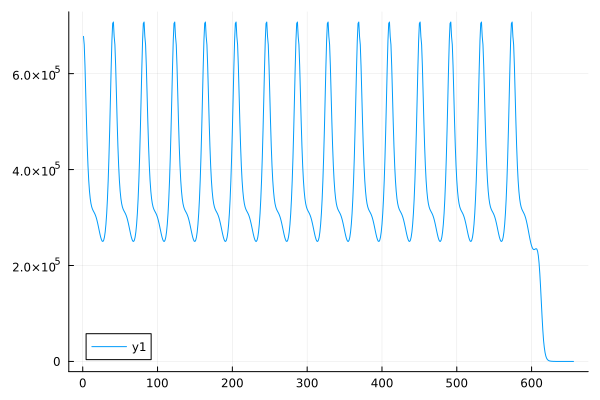

In [96]:
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [97]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

[:, :, 2] =
     6.60259e5  21989.8     21015.6     …      1.43283e5  2403.21
 21989.8          753.912     707.471       4765.5          78.7191
 21015.6          707.471     682.065       4558.5          72.9909
     1.26418e5   4223.47     4028.51       27429.9         459.291
     1.43283e5   4765.5      4558.5        31096.0         521.866
  2403.21          78.7191     72.9909  …    521.866         9.85292

[:, :, 3] =
      6.16403e5  67591.2    17105.9     116520.0        1.42578e5  1056.98
  67591.2         7426.17    1881.04     12788.8    15

In [98]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V, dims=3)

6×6×82 Array{Float64, 3}:
[:, :, 1] =
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

[:, :, 2] =
     6.60259e5  21989.8     21015.6     …      1.43283e5  2403.21
 21989.8          753.912     707.471       4765.5          78.7191
 21015.6          707.471     682.065       4558.5          72.9909
     1.26418e5   4223.47     4028.51       27429.9         459.291
     1.43283e5   4765.5      4558.5        31096.0         521.866
  2403.21          78.7191     72.9909  …    521.866         9.85292

[:, :, 3] =
      6.16403e5  67591.2    17105.9     116520.0        1.42578e5  1056.98
  67591.2         7426.17    1881.04     12788.8    15

In [99]:
V_first = V_2orbits[:,:,1]

6×6 Matrix{Float64}:
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

In [100]:
V_first'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

In [101]:
difference = V_first - V_first'

6×6 Matrix{Float64}:
  0.0          -2.91038e-11   6.73026e-10  …   5.82077e-11  -5.63887e-11
  2.91038e-11   0.0           3.96312e-10     -1.72804e-11  -4.10409e-11
 -6.73026e-10  -3.96312e-10   0.0             -3.00133e-11   1.44951e-11
 -2.91038e-11  -2.72848e-12   3.44698e-10      1.09139e-11  -3.03544e-11
 -5.82077e-11   1.72804e-11   3.00133e-11      0.0          -4.3201e-12
  5.63887e-11   4.10409e-11  -1.44951e-11  …   4.3201e-12    0.0

In [102]:
difference2 = V_2orbits[:,:,2] - V_2orbits[:,:,2]'

6×6 Matrix{Float64}:
  0.0           4.00178e-11   5.89353e-10  …   5.82077e-11  -1.0732e-10
 -4.00178e-11   0.0           3.6971e-10      -2.09184e-11  -7.50902e-11
 -5.89353e-10  -3.6971e-10    0.0             -7.27596e-12   1.42251e-11
 -5.82077e-11   9.09495e-12   3.38332e-10      3.63798e-12  -6.26414e-11
 -5.82077e-11   2.09184e-11   7.27596e-12      0.0          -2.84217e-12
  1.0732e-10    7.50902e-11  -1.42251e-11  …   2.84217e-12   0.0

In [103]:
symmetric_v1 = (V_first + V_first')/2

6×6 Matrix{Float64}:
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

In [104]:
#needed for the quadratic constraint
invsymmetricv1 = inv(symmetric_v1)

6×6 Matrix{Float64}:
  23.9514     24.1299     0.694857  -70.5867   -42.2543   -4.00547
  24.1299     26.158      0.607885  -73.5346   -39.7097   -4.30188
   0.694857    0.607885   0.379749   -2.06917   -1.33121   1.44464
 -70.5867    -73.5346    -2.06917   211.332    120.688    11.5889
 -42.2543    -39.7097    -1.33121   120.688     79.0484    6.71453
  -4.00547    -4.30188    1.44464    11.5889     6.71453   9.24679

In [105]:
invsymmetricv1 - invsymmetricv1'

6×6 Matrix{Float64}:
  0.0           6.55493e-10   4.31422e-12  …   1.03708e-9    4.09388e-11
 -6.55493e-10   0.0          -1.41914e-11      2.20117e-9    1.53179e-10
 -4.31422e-12   1.41914e-11   0.0              3.694e-11     1.87317e-12
  8.92641e-10  -1.03238e-9    1.25313e-11     -4.63088e-9   -2.73063e-10
 -1.03708e-9   -2.20117e-9   -3.694e-11        0.0           1.04877e-10
 -4.09388e-11  -1.53179e-10  -1.87317e-12  …  -1.04877e-10   0.0

In [106]:
display(V_first)

6×6 Matrix{Float64}:
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

In [107]:
#
#x_initial_ref'*inv(V_first)*x_initial_ref

In [108]:
#far_deviation = [1, 0, 1, 0, 1, 0]

In [109]:
#cost to go for this far deviation
#far_deviation'*inv(V_first)*far_deviation

In [110]:
#get the initial delta x
#this is some noise on the reference trajectory

#some arbitrary deviation from the reference trajectory
#x_initial_ref = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]

#this is working
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#this is working. Pretty far deviation in x = 385 km, and vy off by ~1e-3 km/s
#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]


#off by 385 km meters and ~1 mm/s

#x_initial_ref = [1e-3, 0, 0, 0, 1e-6, 0]


#try a small deviation
x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#ensure that the initial deviation is in the unstable manifold direction
#x_initial_ref = [1e-9, -1e-9, 1e-9, 1e-9, -1e-9, 1e-9]

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [111]:
#concatenate unstable directions for 2 orbits

unstable_directions_2 = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
  0.26012      0.278863     0.30114    …   0.246145     0.26012
 -0.28147     -0.270564    -0.258354      -0.291121    -0.28147
  0.00612078   0.00871106   0.0111223      0.00348289   0.00612078
  0.771809     0.817609     0.850311       0.715593     0.771809
 -0.50538     -0.422152    -0.342235      -0.584001    -0.50538
  0.0444626    0.0475123    0.0478662  …   0.0389806    0.0444626

In [112]:
V_2orbits

6×6×82 Array{Float64, 3}:
[:, :, 1] =
 677635.0        -35694.1    23275.5    …      1.38422e5  3721.88
 -35694.1          1907.33   -1216.72      -7297.31       -196.815
  23275.5         -1216.72     816.019      4752.71        125.156
      1.34889e5   -7092.21    4637.76      27551.2         740.474
      1.38422e5   -7297.31    4752.71      28277.3         760.406
   3721.88         -196.815    125.156  …    760.406        21.0185

[:, :, 2] =
     6.60259e5  21989.8     21015.6     …      1.43283e5  2403.21
 21989.8          753.912     707.471       4765.5          78.7191
 21015.6          707.471     682.065       4558.5          72.9909
     1.26418e5   4223.47     4028.51       27429.9         459.291
     1.43283e5   4765.5      4558.5        31096.0         521.866
  2403.21          78.7191     72.9909  …    521.866         9.85292

[:, :, 3] =
      6.16403e5  67591.2    17105.9     116520.0        1.42578e5  1056.98
  67591.2         7426.17    1881.04     12788.8    15

In [113]:
#cost to go level set
epsilon = 1e-6

umax = 0.025

0.025

In [114]:
tube_pose_r = 1e-5
tube_vel_r = 1e-5

1.0e-5

In [115]:
x_initial_ref[:,1]

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [116]:
c_test= unstable_directions[:,1]/tan(pi/6)

manifold_constraint_test = norm(x_initial_ref[:,1]) - c_test'*(x_initial_ref[:,1])

1.8390164016750757e-9

In [117]:
dot(x_initial_ref[:,1], unstable_directions[:,1])

-2.452600336235157e-10

In [118]:
dot(reference_trajectory[:,1] + x_initial_ref, unstable_directions[:,1])

0.20206427045237113

In [119]:
test = (reference_trajectory[:,1] + x_initial_ref)/norm(reference_trajectory[:,1] + x_initial_ref)

6-element Vector{Float64}:
 0.9877608785330818
 0.0
 0.0052377678509247
 0.0
 0.15588782065156404
 0.0

In [120]:
dot(test, unstable_directions[:,1])

0.1781857723583312

In [121]:
L

385000.0

In [122]:
dot(x_initial_ref, unstable_directions[:,1])

-2.452600336235157e-10

In [123]:
#formulate the problem at every solve

#BUG: should also be sending in the updated cost to go and unstable directions matrices as you go along the orbit

#pass in the initial condition, along with jacobians of the current reference trajectory 
function update_prob(x_initial_k, all_Ad_k, all_Bd_k, P_k, unstable_directions_k)
    
    #clear the constraints and decision variables every run
    #cons = 0
    #U = 0
    
    X = Variable(nx,N_h)
        
    U = Variable(nu, N_h-1)
    
    #initial state constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #state constraints
    #Dynamics constraint (for the entire horizon)
    
    # for k=1:(N_h-1)
    #     #these are the dynamics for delta x
        
    #     #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
    #     push!(cons, X[:,k+1] == all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    # end


    #dynamics constraint V2
    for k=1:(N_h-1)
        #these are the dynamics for delta x
        
        #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
        push!(cons, zeros(6) == X[:,k+1] - all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    end
    
    #already propagating the deltas since we are linearizing the dynamics about the reference trajectories
    
#     for k=1:(N_h-1)        
#         #Box constraints on the deviation from the reference trajectory
                
#         push!(cons, X[1,k] <= xmax)
#         push!(cons, X[1,k] >= -xmax)
#         push!(cons, X[2,k] <= ymax)
#         push!(cons, X[2,k] >= -ymax)
#         push!(cons, X[3,k]<= zmax)
#         push!(cons, X[3,k] >= -zmax)
         
#     end
    
    
    #tube constraint
    #for k=2:(N_h-1) #this was there before and works
    #THIS WORKS
    # for k=2:N_h 
    #    push!(cons, norm(X[1:3,k],2) <= tube_pose_r)
    
    #    push!(cons, norm(X[4:6,k],2) <= tube_vel_r)
         
    # end
    
    
    #cost to go constraint (working)
    # for k=2:N_h
        
    #    costtogo = P_k[:,:,k]
        
    #    costtogo_hermitian = (costtogo + costtogo')/2
        
    #    #relaxing bc of the manifold constraint
    #    ctg_constraint = quadform(X[:,k], costtogo_hermitian) <= epsilon
        
    #    push!(cons, ctg_constraint)
                
    # end
    
    #manifold constraint (useful)
    #the delta x needs to be normalized
    #exits to the left with the negative sending
    #this is what is used. for some reason it is being infeasbile in problem 2
   #for k=1:N_h
#     for k=2:N_h 
        
#       #this works the best. investigate why 
#       #manifold goes to the left.  (w no ctg constraint)
#       #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.5*norm(X[:,k]))
        
        
#       #testing  (working) 
#       #goes left with positive unstable direction
#       manifold_constraint = dot(X[:,k], 1*unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.1*norm(X[:,k]))

#       #push!(cons, manifold_constraint >= 0)

#       #trying out 
#       push!(cons, manifold_constraint > 0)

                
        
#    end

    # for k = 2:N_h
            
    #         #manifold goes to the right
    #         manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
    
    #         push!(cons, 1-manifold_constraint >= 0)
    #         push!(cons, 1-manifold_constraint < 1)
    
    # end

   #manifold glideslope constraint for the whole unstable direction

#    for k=2:N_h
#     for k=1:N_h

#         #works with pi/5 too
#         c = unstable_directions_k[:,k]/tan(pi/6)

#         manifold_constraint = norm(X[:,k]) - c'*(X[:,k])

#         push!(cons, manifold_constraint <= 0)

#    end

#just for position
   for k=2:N_h
        
    #works with pi/5 too
    c = unstable_directions_k[:,k]/tan(pi/6)
    #c = unstable_directions_k[:,k]/tan((pi/2) - deg2rad(60)

    manifold_constraint = norm(X[:,k]) - c'*X[:,k]

    push!(cons, manifold_constraint <= 0)

end

    
     
    #Controls Constraint
    
    for k=1:(N_h-1)
        
      push!(cons, norm(U[1:3, k]) <= umax)

    end
        
    #    push!(cons, U[1:3, k]> umin)
        
        
        #not working
        #σ = U[4,k]
        
        #convexified non convex constraint lower bound
        #push!(cons, umin <= σ)
        
        #convexified non convex constraint upper bound
        #push!(cons, σ <= umax)
        
        #convex upper bound on the thrust norm
        #push!(cons, norm(U[1:3,k]) <= σ)
        
        
        #upper bound
        #push!(cons, norm(U[1:3,k]) <= min(σ, umax))
        
        
    #end
    
    #print("done")
    
    return cons, X, U
        
end

update_prob (generic function with 1 method)

In [124]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [125]:
unstable_directions[:,1]

6-element Vector{Float64}:
  0.2601199344043385
 -0.28147013927572373
  0.006120783674633997
  0.7718088379884933
 -0.5053799680278542
  0.044462590430748905

In [126]:
#create the optimization problem

function solve_opt(cons, X, U, N)
    
    #these are tuning parameters
    
    #controls how tight you are tracking the reference 
    #α = 1e3
    
    #controls how much control effort you want to use (high value = low control)
    #β = 1e6
    #β = [1e6, 1e6, 1e15]
    #β = [1e3, 1e3, 1e3]
    #works with 1
    #works good with 1e-4 on just tracking and 0 on controls
    #β = 0
    #α = 1e-5

    #testing
    β = 1
    α = 1e-2

    
    #β = 1 #some of the revs are slow to solve and solution may be innacurate
    
    #the cost function (L1 norm on the cost and the tracking error)
    obj = 0
    
    #for k=1:N
    #    obj += α*norm(X[:,k], 1)
    #end
    
    
    #for a lyaponov orbit we want to stay in the x y plane, so we penalize z maneuvers heavily while 
    #allowing for x and y
    
    for k=1:N-1
        
       #obj += β[1]*abs(U[1,k])+β[2]*abs(U[2,k]) +β[3]*abs(U[3,k])  
        
       #obj += β*norm(U[:,k], 1)
        
        #use L2 norm
        
        #^2 doesn't work in Convex.jl. have to use quadform 
        #obj += β*(norm(U[:,k]))^2 + α*(norm(X[:,k]))^2

        #obj = (norm(X[:,k]))^2

        
        #Px = 1.0*Matrix(I,6,6)

        #Pu = 1.0*Matrix(I,3,3)  
        #this gives the expected behavior with the manifolds but it does not minimize for cost
        #obj += quadform(X[:,k], Px; assume_psd=false)

        #obj += quadform(U[:,k], Pu; assume_psd=false)
        
        #this cost function works good, but gives continous thrust 
        #obj += quadform(U[:,k], Pu; assume_psd=false) + quadform(X[:,k], Px; assume_psd=false)
        obj += β*norm(U[:,k], 1) + α*norm(X[:,k], 1)
        #obj += norm(U[:,k], 1)
        #obj += norm(X[:,k], 2) 
        
    end
            
    
    prob = minimize(obj, cons);
    
    #this objective function is working
    #prob = minimize(norm(X[:,end]), cons);
    
    #this works too
    #prob = minimize(quadform(X[:,end], Q), cons)
    
    #print("mosek solving")
    #solve the problem with Mosek
    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver=true);
    
    #solve the problem with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=false);
    
    Xm = X.value;
    Um = U.value;

    display(prob.status)
    
    return Xm, Um
    
end

solve_opt (generic function with 1 method)

In [127]:
#Q = Matrix(I,6,6).*[1e7*ones(3); 1e7*ones(3)]

#the manifold constraint is the one that is not being satisfied. I think it has to do with numerical conditioning as the values are very small


In [128]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [129]:
reference_trajectory[:,1] - reference_trajectory[:,end]

6-element Vector{Float64}:
  5.507447164987411e-9
 -6.570385800730957e-9
  1.346415930136846e-10
  1.633346660459268e-8
 -1.0701272729063405e-8
  9.59632381217647e-10

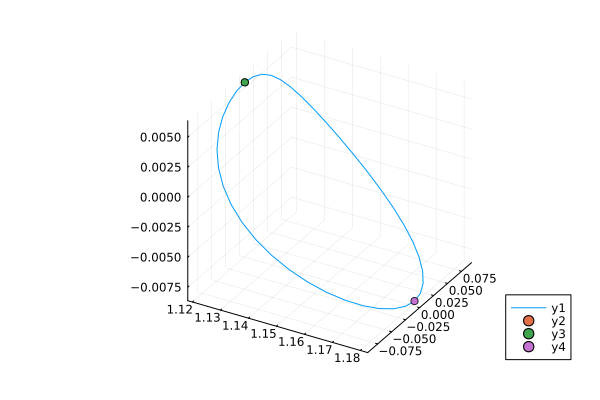

In [130]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])


#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

In [131]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [132]:
#reference_traj_1 = [reference_trajectory reference_trajectory]

In [133]:
#just test to see if it solves

all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

#there was nothing in place for all_Ad_1, maybe a bug? 
display("updating prob")
cons, X, U = update_prob(x_initial_ref, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2)
display("solving")
display(X)
Xm, Um = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 82)
sign: real
vexity: affine
id: 281…116

OPTIMAL::TerminationStatusCode = 1

([1.0e-9 9.723568565842598e-10 … 6.404963032291549e-7 8.20171655282503e-7; 0.0 2.8482284068056018e-11 … -7.820241717518747e-7 -9.282869884889404e-7; … ; 1.0e-9 -3.132823270826645e-10 … -1.6536672623049242e-6 -1.7847515668149248e-6; 0.0 5.4038418061162335e-11 … 9.414540641372331e-8 1.3651326918862732e-7], [2.1456772646948963e-8 1.2170193431923636e-8 … -5.031256974107431e-10 -2.889392133581861e-10; 1.59098256640096e-8 8.263810299680906e-9 … -3.9041460552452705e-10 -2.364190890926634e-10; 6.995075696239617e-11 3.25181408227238e-11 … -1.8082012009039936e-11 -8.2688129001513e-12])

In [134]:
Um 

3×81 Matrix{Float64}:
 2.14568e-8   1.21702e-8   7.56103e-9   …  -5.03126e-10  -2.88939e-10
 1.59098e-8   8.26381e-9   5.1132e-9       -3.90415e-10  -2.36419e-10
 6.99508e-11  3.25181e-11  1.07698e-11     -1.8082e-11   -8.26881e-12

In [135]:
#normalized_xm2 = Xm[:,2]/norm(Xm[:,2])
#dot(unstable_directions[:,2], normalized_xm2)

In [137]:
#check the constraint

#this is because the constraint is from 2:Nh
constraint_satisfied = zeros(N_h)

for i=1:N_h
    constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
end

#constraint is not being satisfied... has to do with the cost function. whenever I have a
#tracking cost with a weight of 1e-2 and a control cost with scale 1, it doesn't work. However, 
#when I remove the cost on the controls and make the weight less on the tracking (1e-5) it works (up to the last point)

#with just a tracking cost with a weight of 1e-2 it doesn't satisfy the constraint fully

In [138]:
constraint_satisfied[1]

-2.452600336235157e-10

In [139]:
constraint_satisfied[15]

-1.1768547070829686e-10

In [140]:
Xm[:,18]/norm(Xm[:,18])

6-element Vector{Float64}:
  0.6209004079635065
 -0.01828356353879687
  0.18894035969923312
 -0.1265325400262348
  0.7386657182968929
 -0.12966267041536267

In [141]:
unstable_directions[:,18]

6-element Vector{Float64}:
  0.4379219369609577
 -0.12658220784506483
 -0.001575106031230146
  0.8322685676218923
 -0.3143977129574082
 -0.026114177417200762

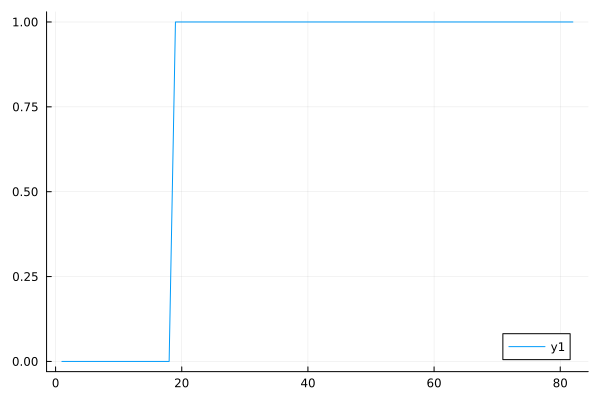

In [142]:
constraint_bool = constraint_satisfied .> 0

plot(constraint_bool)

In [143]:
constraint_bool[44]

true

In [144]:
#for one period 40 controls
xtraj_test = integrate_oneperiod(Xm[:,1] + reference_trajectory[:,1], Um[:,1:40])

6×41 Matrix{Float64}:
 1.12013      1.12017      1.12036     …   1.12018      1.12013
 0.0          0.0150006    0.0294639      -0.0150028   -2.65994e-6
 0.00593968   0.0058125    0.00544062      0.00581252   0.00593973
 0.0          0.00114515   0.0034633      -0.00113959   7.29793e-6
 0.176778     0.173567     0.164317        0.173562     0.176773
 0.0         -0.00295996  -0.00569878  …   0.00296026   4.19799e-7

In [145]:
Xm[:,41]/norm(Xm[:,41])

6-element Vector{Float64}:
  0.17220190616485506
 -0.5801344860607566
 -0.02564289010773309
  0.4449304557676841
 -0.6514089354398983
  0.10409712840686115

In [146]:
unstable_directions[:,end]

6-element Vector{Float64}:
  0.26011993440433845
 -0.28147013927572395
  0.006120783674634001
  0.7718088379884932
 -0.5053799680278541
  0.04446259043074889

In [147]:
dot(Xm[:,41], unstable_directions[:,end])

3.793416807741831e-9

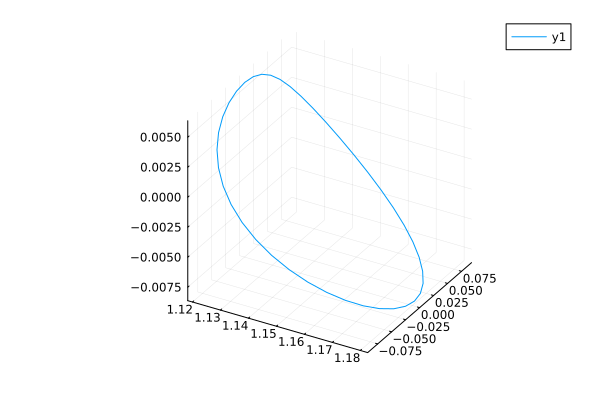

In [148]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [149]:
final = Xm + [reference_trajectory reference_trajectory]

6×82 Matrix{Float64}:
 1.12013      1.12017      1.12036     …   1.12017      1.12013
 0.0          0.0150006    0.0294639      -0.0150013   -9.21717e-7
 0.00593968   0.0058125    0.00544062      0.0058125    0.00593969
 0.0          0.00114515   0.00346331     -0.00114335   2.40594e-6
 0.176778     0.173567     0.164317        0.173565     0.176776
 0.0         -0.00295996  -0.00569878  …   0.00296005   1.35554e-7

In [150]:
#test out the integration function
#xtraj_test = integrate_oneperiod(final[:,1], Um[:,1:39])

In [151]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

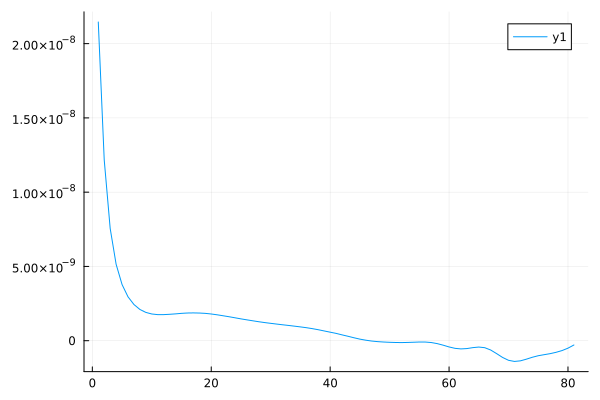

In [152]:
plot(Um[1,:])

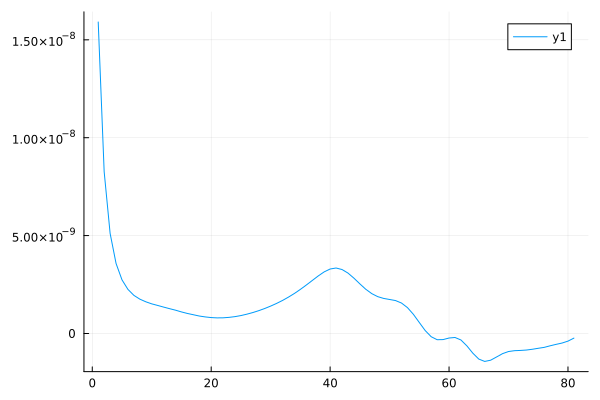

In [153]:
plot(Um[2,:])

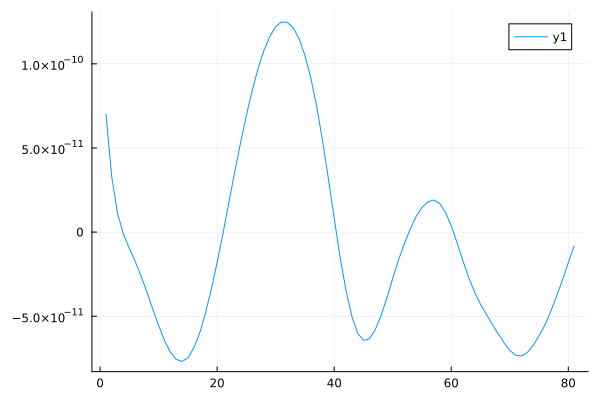

In [154]:
plot(Um[3,:])

In [155]:
Xm[:,21]

6-element Vector{Float64}:
  3.425782753804317e-10
  7.386855000718646e-11
  7.654895310309314e-11
  9.900182567804536e-11
  2.2491267091302969e-10
 -1.3400368447072758e-10

In [156]:
final

6×82 Matrix{Float64}:
 1.12013      1.12017      1.12036     …   1.12017      1.12013
 0.0          0.0150006    0.0294639      -0.0150013   -9.21717e-7
 0.00593968   0.0058125    0.00544062      0.0058125    0.00593969
 0.0          0.00114515   0.00346331     -0.00114335   2.40594e-6
 0.176778     0.173567     0.164317        0.173565     0.176776
 0.0         -0.00295996  -0.00569878  …   0.00296005   1.35554e-7

In [157]:
N_h

82

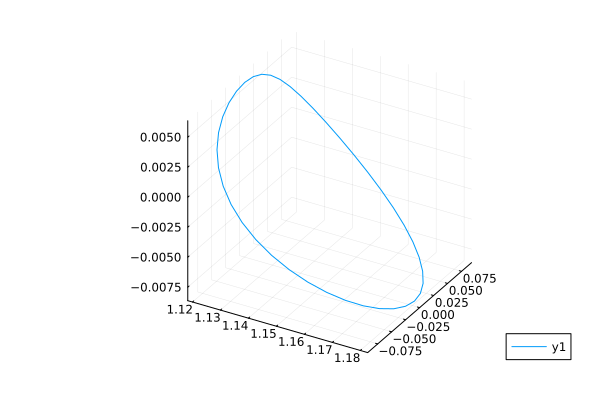

In [158]:
#check out the 1 period solve

#the x trajectory is generated using the linear dynamics
plot(final[1,1:41], final[2,1:41], final[3,1:41])
#scatter!([final[1,1]], [final[2,1]], [final[3,1]])

In [159]:
1e-5*V

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  6.77635    -0.356941     0.232755     1.34889      1.38422      0.0372188
 -0.356941    0.0190733   -0.0121672   -0.0709221   -0.0729731   -0.00196815
  0.232755   -0.0121672    0.00816019   0.0463776    0.0475271    0.00125156
  1.34889    -0.0709221    0.0463776    0.26857      0.275512     0.00740474
  1.38422    -0.0729731    0.0475271    0.275512     0.282773     0.00760406
  0.0372188  -0.00196815   0.00125156   0.00740474   0.00760406   0.000210185

[:, :, 2] =
 6.60259    0.219898     0.210156     1.26418     1.43283     0.0240321
 0.219898   0.00753912   0.00707471   0.0422347   0.047655    0.000787191
 0.210156   0.00707471   0.00682065   0.0402851   0.045585    0.000729909
 1.26418    0.0422347    0.0402851    0.242129    0.274299    0.00459291
 1.43283    0.047655     0.045585     0.274299    0.31096     0.00521866
 0.0240321  0.000787191  0.000729909  0.00459291  0.00521866  9.85292e-5

[:, :, 3] =
 6.16403    0.675912    0.171059   

In [160]:
norm(final[:,1] - final[:,40])

0.015665885043827647

In [161]:
#this initial condition is working
#x_initial_ref = [1e-4, 0, 0, 0, 1e-4, 0]

#x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]


#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]

In [162]:
xposedeviation = x_initial_ref[1] * L*1e3 #in meters

vyposedeviation = x_initial_ref[5]*V_*1e3 #in m/s

display(xposedeviation)
display(vyposedeviation)

0.385

1.025e-6

In [163]:
#this is one set of jacobians. if starting from beginning 

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [164]:
all_Ad[:,:,21:end]

6×6×21 Array{Float64, 3}:
[:, :, 1] =
  1.02016      -0.000262999  -0.000825481  …   0.00728994  -2.34958e-5
 -0.00114643    0.995394      4.69699e-5       0.0848283    1.00275e-6
 -0.000827487   2.17097e-8    0.99178         -1.00275e-6   0.0851403
  0.472695     -0.0092422    -0.0193294        0.170803    -0.000825481
 -0.0402873    -0.107545      0.00164969       0.980815     4.69699e-5
 -0.0194233     1.27128e-6   -0.192292     …  -4.69699e-5   0.99178

[:, :, 2] =
  1.02002      -0.00159618  -0.000815328  …  0.00725189  -2.32287e-5
 -0.00248028    0.995547     0.000100523     0.0848304    2.53036e-6
 -0.000820389   5.41089e-5   0.991768        5.42068e-7   0.08514
  0.468501     -0.0404276   -0.0190557       0.169466    -0.000815328
 -0.0714966    -0.103072     0.00289803      0.980891     0.000100523
 -0.0192567     0.0012699   -0.19257      …  7.38916e-6   0.991768

[:, :, 3] =
  1.01976      -0.00288821   -0.000791588  …  0.00721481  -2.25735e-5
 -0.00377442    0.995845      0.

In [165]:
#another set of jacobians if starting from half

all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,1:20], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,1:20], dims=3)

all_Ad_2 = cat(all_Ad_half, all_Ad_half, dims=3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half, dims=3)

#All Ad1 is if you start from the beginning (2 orbits worth of jacobians) and all_Ad_2 is if you start from the half (2 orbits worth of jacobians).
#need to also have two sets of cost to go and unstable direction matrices that we pass in in the update_prob function 

6×3×82 Array{Float64, 3}:
[:, :, 1] =
  0.00364778    0.000207445  -5.0153e-7
 -0.000207445   0.00363274    1.71242e-8
 -5.0153e-7    -1.71242e-8    0.0036394
  0.085533      0.00728994   -2.34958e-5
 -0.00728994    0.0848283     1.00275e-6
 -2.34958e-5   -1.00275e-6    0.0851403

[:, :, 2] =
  0.00364774   0.000206633  -4.96107e-7
 -0.000208257  0.00363278    4.97734e-8
 -4.98347e-7   1.58188e-8    0.00363939
  0.0855311    0.00725189   -2.32287e-5
 -0.00732801   0.0848304     2.53036e-6
 -2.33598e-5   5.42068e-7    0.08514

[:, :, 3] =
  0.00364762   0.000205841  -4.82385e-7
 -0.000209051  0.00363292    8.02406e-8
 -4.86736e-7   4.71511e-8    0.00363937
  0.0855258    0.00721481   -2.25735e-5
 -0.00736519   0.0848368     3.95242e-6
 -2.28283e-5   2.01478e-6    0.0851389

;;; … 

[:, :, 80] =
  0.00364745    0.000209808  -4.67305e-7
 -0.000205087   0.00363313   -7.51187e-8
 -4.61091e-7   -1.06818e-7    0.00363933
  0.0855177     0.00740068   -2.19289e-5
 -0.00717947    0.0848468    -3

In [166]:
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,1:20], dims=2)
V_half = cat(P[:,:,21:end], P[:,:,1:20], dims=3)

#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half, dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half, dims=3)

6×6×1312 Array{Float64, 3}:
[:, :, 1] =
      2.8048e5   -96305.5    -8232.1     …   39922.6    -1954.58
 -96305.5         33087.6     2831.85       -13712.8      669.728
  -8232.1          2831.85     249.525       -1172.93      55.0293
      1.06689e5  -36625.8    -3129.75        15183.9     -743.885
  39922.6        -13712.8    -1172.93         5683.88    -277.896
  -1954.58          669.728     55.0293  …    -277.896     14.5248

[:, :, 2] =
     2.72885e5      -1.0787e5  -7743.99    …   36331.2    -1540.94
    -1.0787e5    42657.1        3065.73       -14368.2      607.43
 -7743.99         3065.73        226.698       -1032.72      40.9646
     1.05929e5  -41866.9       -3004.52        14100.4     -598.725
 36331.2        -14368.2       -1032.72         4839.94    -204.531
 -1540.94          607.43         40.9646  …    -204.531     10.0455

[:, :, 3] =
     2.65531e5      -1.18123e5  -7162.97    …   33271.3    -1106.06
    -1.18123e5   52560.8         3190.26       -14808.5      

In [167]:
#pseudo code

orbit_count = 0
orbits = true

#number of orbits you want to plan go for
orbit_num = 100


halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)


#optimal_Δx[:,1] = x_initial_ref


#while orbits
    
#    orbits=false
    
#for i=1:N_period-1
 
#i is now the number of times it orbits
for i=1:halforbit_num
        
    #Ad_k = cat(all_Ad_3p[:,:,i:end],all_Ad_3p[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd_3p[:,:,i:end],all_Bd_3p[:,:,1:(i-1)], dims=3)
    
    #Ad_k = cat(all_Ad[:,:,i:end],all_Ad[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd[:,:,i:end],all_Bd[:,:,1:(i-1)], dims=3)
    
    #Ad_k = all_Ad_3p[:,:,1:N_h]
    #Bd_k = all_Bd_3p[:,:,1:N_h]
      
    #horizon is two orbits ahead
    #all_Ad_k = cat(Ad_k, Ad_k, dims=3)
    #all_Bd_k = cat(Bd_k, Bd_k, dims=3)
        
    #cons, X, U = update_prob(optimal_Δx[:,i], all_Ad_k, all_Bd_k)
    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1        
    else
        #println("using jacobian 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
    end
        
    cons, X, U = update_prob(x_initial_ref, all_Ad_k, all_Bd_k, P_k, unstable_directions_k)
        
    Xm, Um = solve_opt(cons, X, U,N_h)
    
    #get the optimal controls for half a period (20 for this example)
        
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    
    if i%2 != 0
        
        #print("from beginning")
        
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #print("this is reference trajectory at half: ", reference_trajectory[:,21])
        #println("from half")
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref = all_optimal_Δx[:,end, orbit_count]

    #println("this is the initial condition for the next rev: ", x_initial_ref)
    
end  

OPTIMAL::TerminationStatusCode = 1

OPTIMAL::TerminationStatusCode = 1

Half Revolution solved: 1
Half Revolution solved: 2


SLOW_PROGRESS::TerminationStatusCode = 19

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


MethodError: MethodError: no method matching getindex(::Nothing, ::Colon, ::UnitRange{Int64})

In [168]:
all_optimal_Δx

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 1.0e-9   1.80821e-9    2.56452e-9   …   7.54258e-8   1.03594e-7
 0.0      6.78948e-10   3.43726e-9      -2.11104e-8  -2.94887e-8
 0.0      1.3686e-10    3.31118e-10     -1.16241e-9  -2.27935e-9
 0.0     -7.75977e-10  -1.41326e-8       1.37558e-7   1.55537e-7
 1.0e-9   6.94844e-9    8.59773e-9      -8.21691e-8  -1.39065e-7
 0.0     -4.31484e-10  -2.44113e-9   …  -4.7955e-9   -5.98323e-9

[:, :, 2] =
  1.03594e-7   1.12489e-7   1.55074e-7  …   3.94468e-6   5.08578e-6
 -2.94887e-8  -4.4779e-8   -7.50089e-8     -4.57982e-6  -5.40905e-6
 -2.27935e-9  -2.45643e-9  -4.04713e-9      5.77628e-8   1.20432e-7
  1.55537e-7   3.57571e-7   3.99523e-7      1.16361e-5   1.52453e-5
 -1.39065e-7  -2.6809e-7   -3.54858e-7     -9.41325e-6  -9.95908e-6
 -5.98323e-9  -1.12003e-8  -1.54588e-8  …   6.1842e-7    8.61837e-7

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0 

In [170]:
rev1 = all_optimal_x[:,:,1]
rev2 = all_optimal_x[:,:,2]
rev3 = all_optimal_x[:,:,3]
rev4 = all_optimal_x[:,:,4]
rev5 = all_optimal_x[:,:,5]
rev20 = all_optimal_x[:,:,20]

rev59 = all_optimal_x[:,:,59]
rev60 = all_optimal_x[:,:,60]
#rev25 = all_optimal_x[:,:,25]

6×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

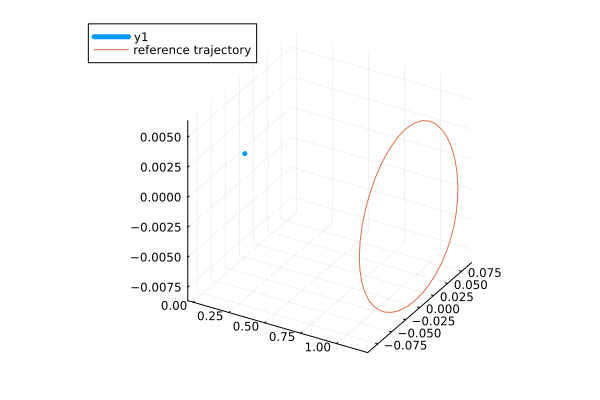

In [171]:
plot(rev1[1,:], rev1[2,:], rev1[3,:], lw=5)
#scatter!([rev1[1,1]],[rev1[2,1]],[rev1[3,1]], lw=5)
plot!(rev2[1,:], rev2[2,:], rev2[3,:], lw=5)
plot(rev3[1,:], rev3[2,:], rev3[3,:], lw=5)
#plot(rev4[1,:], rev4[2,:], rev4[3,:], lw=5)
#plot(rev5[1,:], rev5[2,:], rev5[3,:], lw=5)
#plot!(rev59[1,:], rev59[2,:], rev59[3,:], lw=5)
#plot!(rev60[1,:], rev60[2,:], rev60[3,:], lw=5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="reference trajectory")

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

In [172]:
1e-3*L

385.0

In [173]:
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [174]:
#have orbit_num trajectories of N knot points

for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [175]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 1.12013      1.12017      1.12036     …   1.18028      1.18083
 0.0          0.0150006    0.0294639       0.0132873   -2.93842e-8
 0.00593968   0.0058125    0.00544062     -0.008135    -0.00820272
 0.0          0.00114515   0.0034633       0.0128119    1.5585e-7
 0.176778     0.173567     0.164317       -0.154424    -0.156243
 0.0         -0.00295996  -0.00569878  …  -0.00158451  -5.98776e-9

[:, :, 2] =
  1.18083      1.18028      1.17866     …   1.12018      1.12013
 -2.93842e-8  -0.0132874   -0.0262656      -0.0150051   -5.40248e-6
 -0.00820272  -0.00813501  -0.00793279      0.00581255   0.0059398
  1.5585e-7   -0.0128114   -0.0251095      -0.00113353   1.52289e-5
 -0.156243    -0.154424    -0.149018        0.173557     0.176768
 -5.98776e-9   0.00158449   0.00314719  …   0.00296057   8.60878e-7

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0 

In [176]:
all_optimal_x_formatted

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 1.12013      1.12017      1.12036     …   1.12018      1.12013
 0.0          0.0150006    0.0294639      -0.0150051   -5.40248e-6
 0.00593968   0.0058125    0.00544062      0.00581255   0.0059398
 0.0          0.00114515   0.0034633      -0.00113353   1.52289e-5
 0.176778     0.173567     0.164317        0.173557     0.176768
 0.0         -0.00295996  -0.00569878  …   0.00296057   8.60878e-7

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0

In [177]:
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))
#all_xtraj = reshape(all_optimal_x, (6, 210))

6×4100 Matrix{Float64}:
 1.0e-9   1.80821e-9    2.56452e-9   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      6.78948e-10   3.43726e-9      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0      1.3686e-10    3.31118e-10     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     -7.75977e-10  -1.41326e-8      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0e-9   6.94844e-9    8.59773e-9      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0     -4.31484e-10  -2.44113e-9   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [178]:
for i=1:100
    deltaxsub = all_Δxtraj[41*(i-1)+1:41*i]

    for i=1:41
        plot(deltaxsub[1,:], deltaxsub[2,:], deltaxsub[3,:], lw=5)
    end
end

In [179]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
 2.14568e-8   1.21702e-8   7.56103e-9   …   1.84019e-9    1.79761e-9
 1.59098e-8   8.26381e-9   5.1132e-9        8.45731e-10   8.12569e-10
 6.99508e-11  3.25181e-11  1.07698e-11     -3.39219e-11  -1.80324e-11

[:, :, 2] =
  2.21321e-6   5.66891e-7   5.95591e-7  …  6.2617e-7   5.77746e-7  5.96937e-7
 -1.37432e-6  -7.43492e-9  -5.34445e-9     1.32848e-8  3.37195e-8  3.07247e-7
 -4.41646e-8  -3.00438e-8  -2.31412e-8     2.85623e-8  3.53798e-8  3.40469e-8

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 198] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [180]:
all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

3×4000 Matrix{Float64}:
 2.14568e-8   1.21702e-8   7.56103e-9   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.59098e-8   8.26381e-9   5.1132e-9       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.99508e-11  3.25181e-11  1.07698e-11     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [181]:
all_utraj

3×4000 Matrix{Float64}:
 2.14568e-8   1.21702e-8   7.56103e-9   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.59098e-8   8.26381e-9   5.1132e-9       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.99508e-11  3.25181e-11  1.07698e-11     0.0  0.0  0.0  0.0  0.0  0.0  0.0

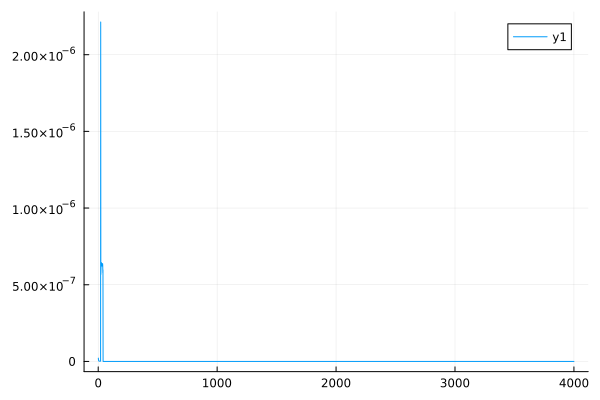

In [182]:
plot(all_utraj[1,:])

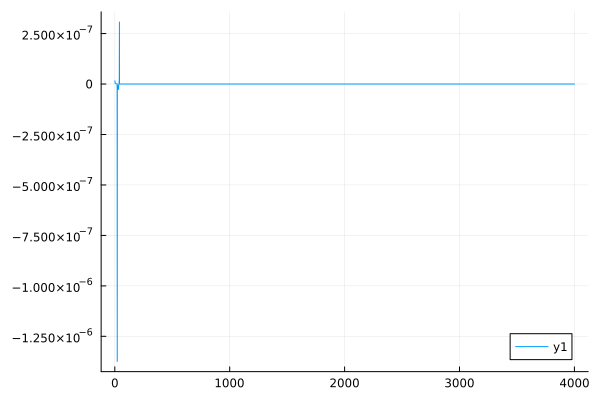

In [183]:
plot(all_utraj[2,:])

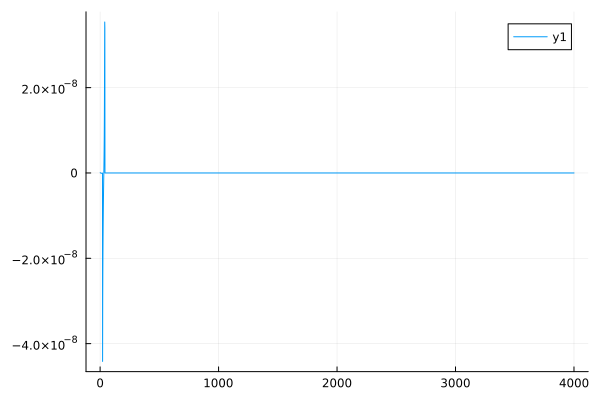

In [184]:
plot(all_utraj[3,:])

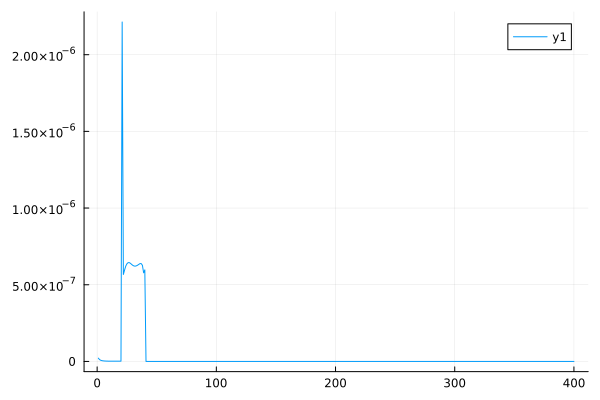

In [185]:
#this is for 10 orbits
plot(all_utraj[1,1:400])

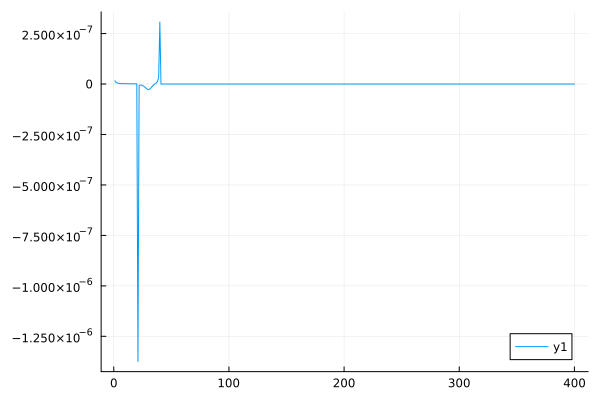

In [186]:
plot(all_utraj[2,1:400])

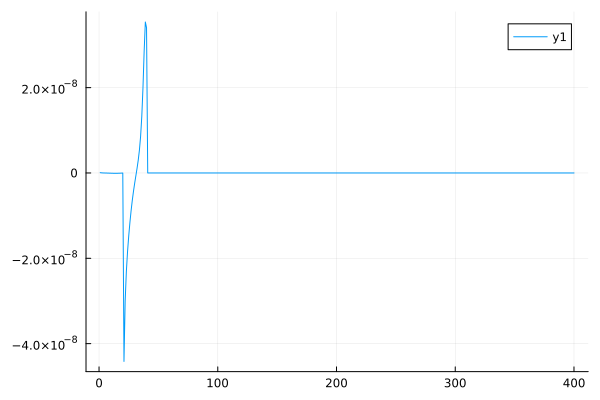

In [187]:
plot(all_utraj[3,1:400])

In [188]:
size(all_utraj)

(3, 4000)

In [189]:
one_orbit = all_utraj[:,1:40]

3×40 Matrix{Float64}:
 2.14568e-8   1.21702e-8   7.56103e-9   …  6.2617e-7   5.77746e-7  5.96937e-7
 1.59098e-8   8.26381e-9   5.1132e-9       1.32848e-8  3.37195e-8  3.07247e-7
 6.99508e-11  3.25181e-11  1.07698e-11     2.85623e-8  3.53798e-8  3.40469e-8

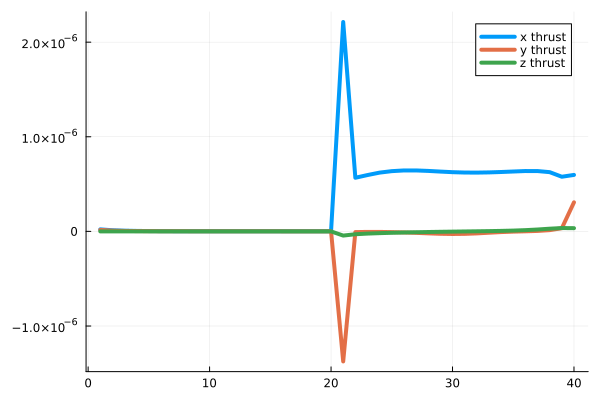

In [190]:
#the beginning thrust is to get it back on track since the initialization is off by 1e-3

plot(one_orbit[1,:], label="x thrust", linewidth=4)

plot!(one_orbit[2,:], label="y thrust", linewidth=4)

plot!(one_orbit[3,:], label="z thrust", linewidth=4)

In [191]:
#once we are at the orbit this is what it looks like
last_orbit = all_utraj[:,3961:end]

3×40 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

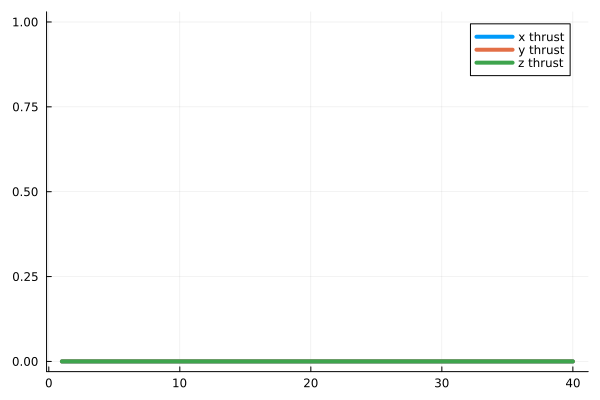

In [192]:
plot(last_orbit[1,:], label="x thrust", linewidth=4)

plot!(last_orbit[2,:], label="y thrust", linewidth=4)

plot!(last_orbit[3,:], label="z thrust", linewidth=4)

In [193]:
all_xtraj

6×4100 Matrix{Float64}:
 1.12013      1.12017      1.12036     …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.0150006    0.0294639      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.00593968   0.0058125    0.00544062     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0          0.00114515   0.0034633      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.176778     0.173567     0.164317       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0         -0.00295996  -0.00569878  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

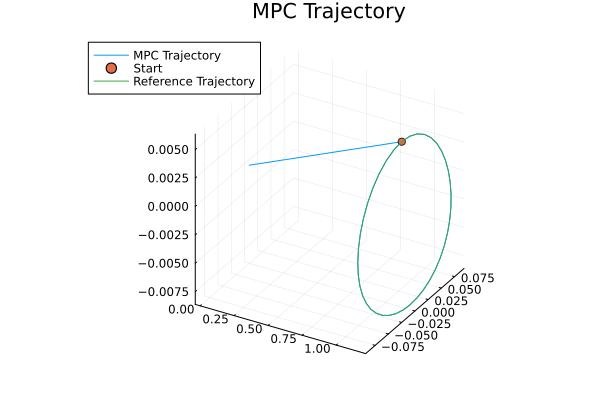

In [194]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

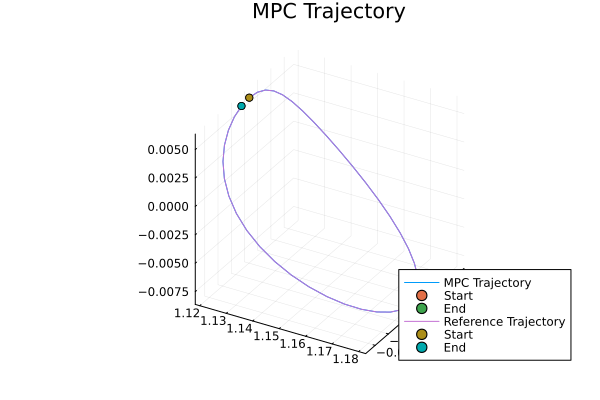

In [195]:
iter = 40

plot(all_xtraj[1,1:iter], all_xtraj[2,1:iter], all_xtraj[3,1:iter], label="MPC Trajectory", title="MPC Trajectory")
scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")
scatter!([all_xtraj[1,iter]], [all_xtraj[2,iter]], [all_xtraj[3,iter]], label="End")
plot!(reference_trajectory[1,1:iter], reference_trajectory[2,1:iter], reference_trajectory[3,1:iter], label = "Reference Trajectory")
scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]], label="Start")
scatter!([reference_trajectory[1,iter]], [reference_trajectory[2,iter]], [reference_trajectory[3,iter]], label="End")


In [196]:
#plot the final orbit
size(all_xtraj)

(6, 4100)

In [197]:
#i = 50
#plot(all_xtraj[1,40*(i-1)+1:40*i], all_xtraj[2,40*(i-1)+1:40*i], all_xtraj[3,40*(i-1)+1:40*i], label="MPC Trajectory", title="MPC Trajectory",lw=3)


#plot!(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory",lw=3)
#plot!(all_xtraj[1,81:120], all_xtraj[2,81:120], all_xtraj[3,81:120], label="MPC Trajectory", title="MPC Trajectory",lw=3)



#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3)


#plot(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory", lw=3)
#plot(all_xtraj[1,81:end], all_xtraj[2,81:end], all_xtraj[3,81:end], label="MPC Trajectory", title="MPC Trajectory", lw=3)

#scatter!([all_xtraj[1,1]],[all_xtraj[2,1]], [all_xtraj[3,1]], label="1")

#scatter!([all_xtraj[1,40]],[all_xtraj[2,40]], [all_xtraj[3,40]], label="40")

#scatter!([all_xtraj[1,41]],[all_xtraj[2,41]], [all_xtraj[3,41]], label="41")

#scatter!([all_xtraj[1,81]],[all_xtraj[2,81]], [all_xtraj[3,81]], label="80")

In [198]:
#plot(optimal_u[1,:].*acceleration_scale)

In [199]:
#plot(optimal_u[2,:])

In [200]:
#plot(optimal_u[3,:])

In [201]:
scaled_control = all_utraj.*acceleration_scale

3×4000 Matrix{Float64}:
 5.8505e-14   3.31838e-14  2.06162e-14  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.33804e-14  2.25325e-14  1.39419e-14     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.90731e-16  8.86654e-17  2.93655e-17     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [202]:
#integrate over the timestep to get the velocity cost in km/s
x_cost = sum(abs.(scaled_control[1,:]))*(Δt*time_scale)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt*time_scale)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt*time_scale)

2.7545961677717316e-8

In [203]:
#velocity cost in m/s
x_cost_ms = x_cost*1e3
y_cost_ms = y_cost*1e3
z_cost_ms = z_cost*1e3

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

0.0012336524456908124

0.0001737397731966316

2.7545961677717316e-5

In [204]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms 

0.0014349381805651613

In [205]:
cost_per_rev = all_cost/orbit_num

1.4349381805651613e-5

In [206]:
#Exclude the first 10 timesteps to fix the injection error
x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt*time_scale) *1e3
y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt*time_scale) *1e3
z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt*time_scale) *1e3

display(x_cost_good)
display(y_cost_good)
display(z_cost_good)

0.0

0.0

0.0

In [207]:
#cost for 95 revs
all_cost_good = x_cost_good + y_cost_good + z_cost_good

0.0

In [ ]:
#final_mpc = reference_trajectory + optimal_x

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")

In [ ]:
#initially
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]],[final_mpc[3,1]], label= "Start Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label= "Start Point")
#scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]], label= "End Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#diff = final_mpc - reference_trajectory

In [ ]:
#plot(diff[1,:])
#plot!(diff[2,:])
#plot!(diff[3,:])

In [ ]:
plot(all_xtraj[1,:], all_xtraj[2,:])

In [ ]:
all_xtraj[:,end]

In [ ]:
all_optimal_x[:,:,end]

In [ ]:
dot(all_optimal_x[:,end,end], unstable_directions_2[:,21])    

In [ ]:
end_state = all_xtraj[:,end]

end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

In [ ]:
#testing
#end_state_sim = reference_trajectory[:,end]

In [ ]:
delta_end = end_state - reference_trajectory[:,end]

In [ ]:
#end_state_test = reference_trajectory[:,end] - delta_end

In [ ]:
#correct_end_state = end_state_test - reference_trajectory[:,end]

In [ ]:
#end_state_sim_correct = just_dynamics_integrate(end_state_test, 2.0*sol_t_final[end])


#end_state_traj_correct = get_state(end_state_sim_correct)

In [ ]:
unstable_directions[:,end]


#for the negative manifold, the final state is satisfying the constraint and that's why it goes to the 
#left 

#however, for the positive manifold, it is satisfying the negative manifold constraint...

In [ ]:
dot(delta_end, unstable_directions[:,end])

In [ ]:
#check this constraint 
#works with pi/5 too 

#c_test = unstable_directions[:,end]/tan(pi/6)
c_test = unstable_directions[:,end]/tan((pi/2) - deg2rad(60))

manifold_constraint_test = norm(delta_end) - c_test'*(delta_end)

manifold_constraint_test
#push!(cons, manifold_constraint <= 0)

In [ ]:
#angle away from the unstable manifold
dot(unstable_directions[:,end], delta_end)*norm(delta_end)*180/pi

In [ ]:
#escapes on the right for positive unstable direction!
plot(end_state_traj[1,:], end_state_traj[2,:])

scatter!([end_state_traj[1,1]], [end_state_traj[2,1]])

In [ ]:
#plot(end_state_traj_correct[1,:], end_state_traj_correct[2,:])

#goes to the right when it is in the positive manifold direction. hypothesis is true. however, 
#the solver is giving solutions that does not satisfy this constraint. need to figure out why...

In [ ]:
#needs to be a super small perturbation in order to stay stable

forward_rollout = zeros(6, N_period)

#forward_rollout[:,1] = [1e-3, 0, 0, 0, 1e-6,0]


forward_rollout[:,1] = [1e-9, 0, 0, 0, 1e-9, 0]

for i=1:N_period-1
   
    #diverges with no control 
    #forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i]
    
    #with disturbances it just blows up
    forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i] #+ randn(6)*1e-4
    
end
    

In [ ]:
reference_trajectory

In [ ]:
nocontrol = forward_rollout + reference_trajectory

In [ ]:
plot(nocontrol[1,:], nocontrol[2,:], nocontrol[3,:], lw=3, label="No Control")
plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
scatter!([nocontrol[1,1]], [nocontrol[2,1]], [nocontrol[3,1]], label="No Control Start")
scatter!([nocontrol[1,end]], [nocontrol[2,end]],[nocontrol[3,end]], label="No Control End")

In [ ]:
# plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], lw=3, label="MPC Control")
# plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
# scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label="No Control Start")
# scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]],  label="No Control End", aspectratio = true)

In [ ]:
position_tube_norm = zeros(N_period*orbit_num)

velocity_tube_norm = zeros(N_period*orbit_num)

In [ ]:
orbit_num

In [ ]:
svd(V[:,:,1]).S

In [ ]:
for i=1:N_period*orbit_num
   
    position_tube_norm[i]= norm(all_Δxtraj[1:3,i])
    
    velocity_tube_norm[i]= norm(all_Δxtraj[4:6,i])
    
end

In [ ]:
ctg_constraint = zeros(6, N_period)
dist_from_center = zeros(6, N_period)

In [ ]:
(ones(6).*0.1)./eigen(V[:,:,1]).values

In [ ]:
test_v = (ones(6).*0.1)./eigen(V[:,:,1]).vectors

In [ ]:
test_v * [1,1,1,0,0,0]

In [ ]:
V

In [ ]:
for i= 1:N_period

    e_decomp = eigen(V[:,:,i])

    #inverse same as transpose in this case
    y = inv(e_decomp.vectors) * all_Δxtraj[:,i]

    dist_from_center[:,i] = y

    ctg_constraint[:,i] = sqrt.(1e-3 .*ones(6)./e_decomp.values)


end

    

In [ ]:
ctg_constraint


In [ ]:
dist_from_center

In [ ]:
all_Δxtraj[:,1]'*V[:,:,1]*all_Δxtraj[:,1]

In [ ]:
dist_from_center[1,:]*L

In [ ]:
plot(dist_from_center[1,:], label="x")
plot!(ctg_constraint[1,:], label="x axis constraint")

In [ ]:
plot(dist_from_center[2,:], label="y")
plot!(ctg_constraint[2,:], label="y axis constraint")

In [ ]:
plot(dist_from_center[3,:], label="z")
plot!(ctg_constraint[3,:], label="z axis constraint")

In [ ]:
plot(dist_from_center[4,:], label="vx")
plot!(ctg_constraint[4,:], label="vx axis constraint")

In [ ]:
plot(dist_from_center[5,:], label="vy")
plot!(ctg_constraint[5,:], label="vy axis constraint")

In [ ]:
plot(dist_from_center[6,:], label="vz")
plot!(ctg_constraint[6,:], label="vz axis constraint")

In [ ]:
all_Δxtraj[:,1]

In [ ]:
V[:,:,1]

In [ ]:
#test.vectors*diagm(test.values)*test.vectors'

In [ ]:
#inv(test.vectors)

In [ ]:
#test.vectors'

In [ ]:
# #finding the magnitude of the principle axes of the ellipsoid
# magnitude_principle_axes = zeros(6, N_period)


# for i=1:N_period
    
#     magnitude_principle_axes[:,i] = svd(V[:,:,i]).S
    
    
# end

In [ ]:
# plot(magnitude_principle_axes[1,:])
# plot!(magnitude_principle_axes[2,:])
# plot!(magnitude_principle_axes[3,:])

In [ ]:
# plot(magnitude_principle_axes[4,:])
# plot!(magnitude_principle_axes[5,:])
# plot!(magnitude_principle_axes[6,:])

In [ ]:
plot(all_Δxtraj[1,:])

plot!(all_Δxtraj[2,:])

plot!(all_Δxtraj[3,:])

In [ ]:
plot(all_Δxtraj[4,:])

plot!(all_Δxtraj[5,:])

plot!(all_Δxtraj[6,:])